# Ordinary Differential Equations (ODEs) and Boundary Conditions (BCs)

## ODEs

$$	\frac{d^{2}u_{1}}{dz_{1}^{2}}-2z_{1}\frac{du_{1}}{dz_{1}}+ \frac{2}{\gamma+1} \frac{\omega^{2}}{\Omega^{2}}u_{1}=0$$
$$\lambda \equiv \frac{1}{\gamma+1}\frac{\omega^{2}}{\Omega^{2}}=n$$
$$y_{1}=u_{1}\exp(-z_{1}^{2})$$
$$y_{2}=\exp(-z_{1}^{2})\frac{du_{1}}{dz_{1}}$$
$$\frac{dy_{1}}{dz_{1}}+2z_{1}y_{1}-y_{2}=0$$
$$\frac{dy_{2}}{dz_{1}}+2ny_{1}=0$$

## BCs

As for the boundary conditions of $u_{1}$, actually, it is both $u_{1}$ and $du_{1}/dz_{1}$ are finite at $z_{1}=\pm\infty$.
It is not a quantitive boundary condition, but a qualitative one.
We may set $z_{1}=\pm10$ as the boundary ($\pm \infty$), and mutiply $u_{1}$ and $du_{1}/dz_{1}$ by $\exp(-z_{1}^{2})$, then we can get the boundary conditions for $y_{1}$ and $y_{2}$ as follows:

### Left Boundary ($z_{1}=-10$):

$$y_{1}=0$$

### Right Boundary ($z_{1}=10$):

$$y_{1}=0$$

If we need to compare the results with the analytical solution, we should compare them just at the range like from $z_{1}=-2.5$ to $z_{1}=2.5$.
We should keep it far away from the boundary. If you would like to compare them at the range like $[-10,10]$, your calculation domain should be larger than $[-10,10]$, like $[-40,40]$.

In [5]:
# -*- coding: utf-8 -*-
"""
Created on April 12, 2024
Last modified on April 12, 2024
@Author: Guan-Fu Liu

To solve the BVP by the method of relaxiation.

Updates:
1. New definition of error
2. Adaptive scale of variables
"""
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
import time
from scipy import special

start = time.time() # The time of the beginning
ne = 2 # The number of the ODEs.
mesh = 1000 # The number of mesh points.
nl = 1 # The number of boundary conditions of the left.
nr = ne - nl # The number of boundary conditions of the right.
itmax = 100 # The maximum number of iterations.
y0 = np.zeros((ne,mesh),dtype=complex)
y0[0,:] = 1
y0[1,:] = 2
# An initial guess of y.
y = y0
z1 = np.linspace(-10, 10, mesh) # The mesh points of x.
n = 4 # Degree of Hermite equation


def difeq(ne,mesh,nl,nr,z1,y):
    """
    Here, this function generates the Matrix and error column that the relaxation method needs.
    This function should be modified according to the BVP you need to solve.
    A \Delta y = -E  
    """
    A = np.zeros((ne*mesh,ne*mesh),dtype=complex)
    E = np.zeros(ne*mesh,dtype=complex)
    for i in range(ne*mesh):
        if i < nl:
            A[0,0:ne:1] = np.array([1,0])
            E[0] = y[0,0]#*np.exp(-z1[0]**2)
        elif i>= nl and i < ne*mesh - nr:
            k = (i-nl)//ne + 1 
            h = z1[k]-z1[k-1]
            if (i-nl)%ne == 0:
                A[i,ne*k-ne:ne*k-ne+2*ne] = np.array([-1+h*2*0.5*(z1[k]+z1[k-1])*0.5,-h*0.5,
                                                      1+h*2*0.5*(z1[k]+z1[k-1])*0.5, -h*0.5])
                E[i] = y[0,k]-y[0,k-1]+h*2*0.5*(z1[k]+z1[k-1])*0.5*(y[0,k]+y[0,k-1])-h*0.5*(y[1,k]+y[1,k-1])
            else:
                A[i,ne*k-ne:ne*k-ne+2*ne] = np.array([0.5*h*2*n,-1,0.5*h*2*n,1])
                E[i] = y[1,k]-y[1,k-1]+h*2*n*0.5*(y[0,k]+y[0,k-1])
        else:
            A[-nr,-ne::1] = np.array([1,0])
            E[-nr] = y[0,-1]#*np.exp(-z1[-1]**2)
    return A, -E


slowc = 1
scalv = np.array([1.0,5.0])
conv = 8e-15
scale_adaptive = False
for i in range(itmax):
    A, E = difeq(ne,mesh,nl,nr,z1,y)
    A = scipy.sparse.csr_matrix(A)
    Delta_y = scipy.sparse.linalg.spsolve(A, E)
    Delta_y = np.reshape(Delta_y,(ne,mesh),order='F')
    E = np.reshape(E,(ne,mesh),order='F')
    # Here, I introduced the adaptive definition of scalv.
    # The typical scale of each component of y is defined
    # as their maximum value in the previous iteration.
    if scale_adaptive:
        scalv = np.maximum(scalv, np.abs(y).mean(axis=1))
    else:
        pass
    # Original definition of error is as follows,
    # which depends on the delta y.
    # err = np.array([Delta_y[j]/scalv[j] for j in range(len(scalv))])
    # err = np.abs(err).sum()/mesh/ne

    # New definition of error
    err = np.array([E[j]/scalv[j] for j in range(len(scalv))])
    err = np.abs(err).sum()/mesh/ne
    fraction = slowc/max(slowc,err)
    if i==0:
        print("       iteration    error           fraction ")
    print("%8d            %0.6e    %0.6e"%(i+1,err,fraction))
    if err < conv:
        print(' The BVP is solved successfully!')
        break
    elif err >= conv and i <=itmax-1:
        y = y + fraction*Delta_y
        continue
    else:
        print(" Exceed the maximum number of iterations!")


end = time.time() # The time of the end.
print("\n The total time of this programme is %0.2e seconds"%(end-start))


       iteration    error           fraction 
       1            1.008000e-01    1.000000e+00
       2            1.072509e-14    1.000000e+00
       3            4.434807e-15    1.000000e+00
 The BVP is solved successfully!

 The total time of this programme is 5.79e-01 seconds


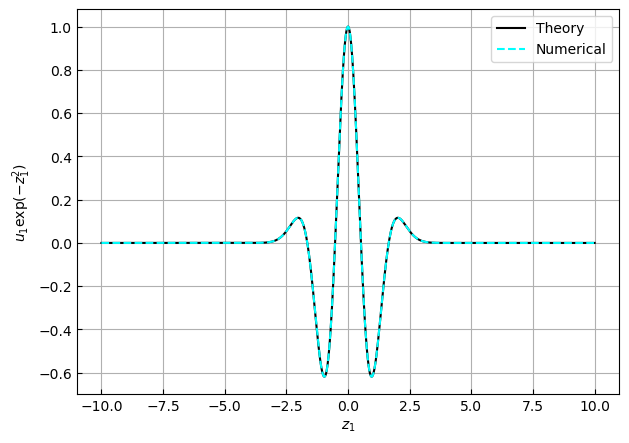

In [6]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5),dpi=100)
p_monic = special.hermite(n, monic=False)
y3 = p_monic(z1)
ax.plot(z1, (y3*np.exp(-z1**2)/(y3*np.exp(-z1**2)).max()),linestyle='-',color='black',label='Theory')
ax.plot(z1,np.real(y[0])/np.real(y[0]).max(),linestyle='--',color='cyan',label='Numerical')
ax.set_xlabel(r'$z_{1}$')
ax.set_ylabel(r'$u_{1}\exp(-z_{1}^{2})$')
ax.legend()
ax.grid()
ax.tick_params(direction='in')

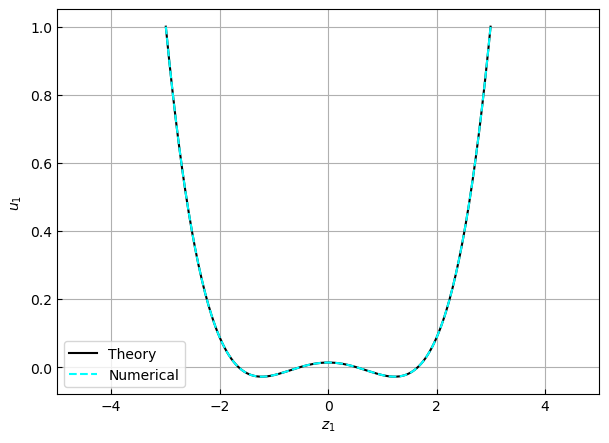

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5),dpi=100)
p_monic = special.hermite(n, monic=False)
y3 = p_monic(z1)
zmask = np.abs(z1) < 3
ax.plot(z1[zmask], y3[zmask]/y3[zmask].max(),linestyle='-',color='black',label='Theory')
ax.plot(z1[zmask], np.real(y[0][zmask]*np.exp(z1[zmask]**2))/np.real(y[0][zmask]*np.exp(z1[zmask]**2)).max(),
        linestyle='--',color='cyan',label='Numerical')
ax.set_xlim(-5,5)
# ax.set_ylim(0,0.1)
ax.set_xlabel(r'$z_{1}$')
ax.set_ylabel(r'$u_{1}$')
ax.legend()
ax.grid()
ax.tick_params(direction='in')